# t-SNE: an introduction

Author:
- Andrea Gentilini, 2024

Resources used for producing this notebook are listed at the end. **Let's get started!**

--------------------------

In this tutorial, we describe a very popular nonconvex technique for learning low dimensional embeddings called [t-SNE](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).
t-SNE is an extension of the earlier **[stochastic neighbor embedding](https://papers.nips.cc/paper_files/paper/2002/file/6150ccc6069bea6b5716254057a194ef-Paper.pdf)**
method. Both methods were developed by Geoffrey Hinton, winner of the Turing Award in 2018, in collaboration with others.

Since t-SNE is an extension of SNE, we will first describe SNE, before analyzing the t-SNE extension.

# Imports and utilities

In [ ]:
# @title Import dependencies

# basics for now
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# SNE: a mediocre but ambitious overview


## Dataset

Suppose we have a dataset $ X $ containing $ N $ data points. Each data point $ \mathbf{x}_{i} $ has $ D $ dimensions. We wish to reduce this to $ d $ dimensions. In this tutorial $ d = 2 \vee 3 $.

In [ ]:
# Load data
digits = datasets.load_digits()
X = digits.data
y = digits.target

X.shape, y.shape # D = 64; N = 1797

((1797, 64), (1797,))

## General Idea

The basic idea in SNE is to convert global Euclidean distances into conditional probabilities that represent local similarities. More precisely, we define $ \mathbf{p}_{ij} $ to be the probability that point $ i $ would pick point $ j $ as its neighbor, if neighbors were picked in proportion to their probability under a Gaussian density centered at $ \mathbf{x}_i $:

$$ p_{ij} = \frac{\exp\left(-\frac{1}{2\sigma_i^2} \|x_i - x_j\|^2\right)}{\sum_{k \neq i} \exp\left(-\frac{1}{2\sigma_i^2} \|x_i - x_k\|^2\right)}  $$

Here $ \sigma ^ 2 $ is the variance for data point $ i $. In fact, each $ \mathbf{x}_{i} $ has its own probability distribution, and consequentely each $ \mathbf{x}_{j} $ has its own variance.


From the formula above, we notice that if:
- $ \mathbf{x}_i \approx \mathbf{x}_j \implies \mathbf{p}_{ij} \approx 1 $

- the distance between $ \mathbf{x}_i $ and $ \mathbf{x}_j $ is large (in terms of Euclidian norm) $ \implies \mathbf{p}_{ij} \to 0 $

**It is evident that our goal will be to maximize the similarity.** 🤓

------------------------
🍪 Let's cook some ingredients...

In [ ]:
def negative_squared_euclidean_distances(Matrix):
    """
    Produces an NxN matrix D where D_{ij} represents the negative
    squared Euclidean distance between data points xi and xj
    from dataset Matrix. This facilitates subsequent calculations.

    Matrix is an NxD dimension matrix.

    # Returns:
        An NxN matrix D, where each element D_ij equals the negative squared
        Euclidean distance between rows Matrix_i and Matrix_j
    """
    # https://stackoverflow.com/questions/37009647
    sum_of_Matrix = np.sum(np.square(Matrix), 1)
    Distance_Matrix = np.add(np.add(-2 * np.dot(Matrix, Matrix.T), sum_of_Matrix).T, sum_of_Matrix)
    return -Distance_Matrix

Since we have $ \exp() / \sum \exp() $ ... let's compute the softmax

In [ ]:
def softmaxx(Matrix, zero_diagonal=True):
    """Computes the softmax of each row in the matrix Matrix."""

    # Subtract the maximum value in each row for numerical stability
    exponentiated_matrix = np.exp(Matrix - np.max(Matrix, axis=1).reshape([-1, 1]))

    # If zero_diagonal is True, set the diagonal elements to zero since self-comparison is not desired
    if zero_diagonal:
        np.fill_diagonal(exponentiated_matrix, 0.)

    # Add a small constant to prevent division by zero in subsequent logarithmic operations
    exponentiated_matrix += 1e-8  # for numerical stability

    return exponentiated_matrix / exponentiated_matrix.sum(axis=1).reshape([-1, 1])

### Exercise

> Use the functions above to create a matrix $ P $: the matrix of probabilities all over the data points.

In [ ]:
# ✏️ your solution here

In [ ]:
# @title 👀 Solution

def calculate_probability_matrix(dist_matrix, perp=None):
    """Transform a matrix of distances into a probability matrix."""
    if perp is not None:
        scaled_distances = 2. * np.square(perp.reshape((-1, 1)))
        return softmaxx(dist_matrix / scaled_distances)
    else:
        return softmaxx(dist_matrix)

Let now $ \mathbf{z}_{i} $ be the low dimensional embedding representing $ \mathbf{x}_{i} $. We define similarities in the low dimensional space in an analogous way:

$$ q_{ij} = \frac{\exp\left(-\|z_i - z_j\|^2\right)}{\sum_{k \neq i} \exp\left(-\|z_i - z_k\|^2\right)} $$

In this case, the variance is fixed to a constant (since changing it would just rescale the learned map, and not change its topology).

But wait one second! If you saw the solution to the previous exercise (and you were not sleeping 😴), you should have noticed a strange optional argument in the solution function...

## 🤔 Perplexity

The `perp` argument should be an N-length vector containing each of the `σi`'s. **How do we determine these `σi`'s?** This is the role of perplexity in SNE. The perplexity of any row in the matrix of conditional probabilities `P` is defined as:

$$ \text{Perp}(P_i) = 2^{H(P_i)} $$

Here $ H(P_i) $ represents the Shannon entropy of $ P_i $ measured in bits:

$$ H(P_i) = -\sum_j p_{ji} \log_2 p_{ji} $$

In SNE (and t-SNE), perplexity is a pre-set parameter, typically ranging from 5 to 50. We adjust the `σi`'s such that the perplexity of each row in $ P $ matches this set perplexity (our chosen parameter).

Consider this concept for a moment: if a probability distribution has high entropy, it suggests a relatively flat distribution – meaning, the probabilities for most elements in the distribution are similar (in fact the max entropy is reached when we have uniform probability).

As entropy increases, so does perplexity. Therefore, if we aim for higher perplexity, we want the probabilities $ p_{ji} $ (for any given $ i $) to be more uniform. In other words, we aim to make the probability distribution $ P_i $ more homogeneous. This is achieved by increasing `σi`. The larger the `σi` used in the denominator, the more uniform the distribution, trending towards every probability being exactly $ 1/N $.

Thus, aiming for higher perplexity implies setting larger `σi` values, which flattens the conditional probability distributions. This effectively increases the number of neighbors each point has (defining $ x_i $ and $ x_j $ as neighbors if $ p_{ji} $ falls below a specific probability threshold). This explains why the perplexity parameter is often loosely equated with the number of neighbors we believe each point to have.



## 🔎 Finding the $ \sigma_{i} $

Essentially, we are setting the perplexity and subsequently constructing the Gaussian distribution accordingly. To guarantee that the perplexity of each row of P, $ Perp(P_i) $, matches our target perplexity, we conduct a binary search on each $ \sigma_{i} $ until $ Perp(P_i) $ reaches our set perplexity.

This approach works because the perplexity $ Perp(P_i) $ is a monotonically increasing function with respect to $ \sigma_{i} $.

(The following implementation is simple but solid and reliable, thanks to Numerical Methods course!).


In [ ]:
def b_search(function_to_evaluate, desired_value, precision=1e-10, iterations_limit=10000,
                          min_value=1e-20, max_value=1000.):
    """Conduct a binary search to find the input value for which the function output matches the desired value.

    # Arguments
        function_to_evaluate: Function to optimize over.
        desired_value: The output value we are targeting from the function.
        precision: Float, the tolerance level below which we stop the search.
        iterations_limit: Integer, the maximum number of iterations to perform.
        min_value: Float, the lower limit of the search range.
        max_value: Float, the upper limit of the search range.
    # Returns:
        Float, the best input value found for the function during the search.
    """
    for i in range(iterations_limit):
        midpoint = (min_value + max_value) / 2.
        result = function_to_evaluate(midpoint)
        if result > desired_value:
            max_value = midpoint
        else:
            min_value = midpoint
        if np.abs(result - desired_value) <= precision:
            break
    return midpoint


To determine our $ \sigma_{i} $, we need to supply a `function_to_evaluate` to the `b_search` function. This function should accept a specific $ \sigma_{i} $ as input and calculate the perplexity of $ \mathbf{P}_{i} $ using that $ \sigma_{i} $.

The `determine_optimal_sigmas` function below achieves precisely this, by identifying all necessary $ \sigma_{i} $ values. It accepts a matrix of negative Euclidean distances and a predefined target perplexity. For each row in the distance matrix, it executes a binary search across potential $ \sigma_{i} $ values until it achieves the target perplexity. It then compiles and returns an array of the optimal $ \sigma_{i} $ values that were determined.


In [ ]:
def calculate_perplexity(probability_matrix):
    """Compute the perplexity for each row in a probability matrix."""
    entropy_values = -np.sum(probability_matrix * np.log2(probability_matrix), axis=1)
    row_perplexities = 2 ** entropy_values
    return row_perplexities

def get_perplexity_of_distances(distance_matrix, scale_factors):
    """Utility function to quickly compute perplexity for a given distance matrix."""
    return calculate_perplexity(calculate_probability_matrix(distance_matrix, scale_factors))

def determine_optimal_sigmas(distance_matrix, desired_perplexity):
    """Identify the scale factor (sigma) for each row of the distance matrix that results
    in the desired perplexity."""
    optimal_sigmas = []
    # Iterate over each row of the distance matrix (each data point)
    for i in range(distance_matrix.shape[0]):
        # Define a function that calculates perplexity for a given sigma
        perplexity_fn = lambda s: \
            get_perplexity_of_distances(distance_matrix[i:i+1, :], np.array([s]))
        # Conduct a binary search to find the sigma that achieves the target perplexity
        optimal_sigma = b_search(perplexity_fn, desired_perplexity)
        # Store the optimal sigma in the list
        optimal_sigmas.append(optimal_sigma)
    return np.array(optimal_sigmas)


## 🛫 What we want
If the embedding is a good one, then $ \mathbf{q}_{ij} $ should match $ \mathbf{p}_{ij} $. Therefore, the SNE objective function is:

$$ L = \sum_i D_{KL}(P_i \| Q_i) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ji}} $$

where:
- $ \mathbf{P}_{i} $ is the conditional distribution over all other data points given $ \mathbf{x}_{i} $ (i.e. $ \mathbf{p}_{ij} $ $ \forall $ $ i,j $ ; with $ \mathbf{p}_{ii} = 0 $ )
- $ \mathbf{Q}_{i} $ is the conditional distribution over all other latent points given $ \mathbf{z}_{i} $ (i.e. $ \mathbf{q}_{ij} $ $ \forall $ $ i,j $ ; with $ \mathbf{q}_{ii} = 0 $ )

- $ \mathbf{D}_{KL}(P_i \| Q_i) $ is the KL divergence between the distributions.

**We want to minimize this function wrt $ \mathbf{z}_{i} $. In fact minimizing $ L $ means to reduce the KL divergence (that is our primary goal)**. More intuitively, we want the gaussian distribution of the low-dimensional $ \mathbf{z}_{i} $ to "look similar" (in terms of KL divergence) to the distribution of the high dimensional $ \mathbf{x}_{i} $.


**Before moving on the optimization part, let's observe a couple of pivotal things.**

## The loss is asymmetric

Note that:

$$ L = D_{KL}(P \| Q) = \sum_i D_{KL}(P_i \| Q_i) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ji}} $$

is an asymmetric objective. This means that discrepancies are not treaded equally! In particular, there is a large cost if a small $ \mathbf{q}_{ij} $ is used to model a large $ \mathbf{p}_{ij} $. **This loss will prefer to pull distant points together rather than push
nearby points apart.**

⏰ As a result: local structures are emphasized forming clusters, but distant points tend to crowd together.

## So... symmetric SNE 📐

We now have all the elements necessary to perform SNE: the distributions `q` and `p`. Ideally, we could derive a solid 2D representation `Z` by minimizing the cost function `L` in relation to `Z` through gradient descent until stabilization.

However, why not simplify the process if feasible? Consider adopting Symmetric SNE instead of the standard SNE for a couple of pivotal reasons:

- Hinton, in his paper linked in the introduction, described the symmetric alternative to be "just as good" as the asymmetric.

- The gradient is easier 🤟

In Symmetric SNE, we target minimizing the KL divergence across the joint probability distributions with entries `p_{ij}` and `q_{ij}`, instead of leveraging conditional probabilities. In defining a joint distribution, each `q_{ij}` is calculated as:

$$
q_{ij} = \frac{\exp(-||z_i - z_j||^2)}{\sum_{k \neq l} \exp(-||z_k - z_l||^2)}
$$

This format mirrors the earlier softmax approach, but here, the normalization occurs across the entire matrix, not just within a singular row.

To mitigate issues stemming from outlier `x` points in `p_{ij}`, we simplify by setting:

$$
p_{ij} = \frac{p_{ij} + p_{ji}}{2N}
$$

Implementing these redefined joint distributions `p` and `q` in Python is straightforward:

- The joint `p` is computed as `(P + P^T) / (2N)`, where `P` represents the matrix of conditional probabilities with the entry `(i, j)` being `p_{ji}`.
- The joint `q` can be estimated by computing the negative squared Euclidean distance matrix from `Z`, exponentiating it, and then normalizing by dividing all entries by the total sum.


In [ ]:
def calculate_joint_q(Z):
    """Compute the joint probability matrix q_ij for a given low-dimensional representation Z."""
    # Calculate the negative squared Euclidean distances among all points
    distances = negative_squared_euclidean_distances(Z)
    # Exponentiate each distance to get unnormalized probabilities
    exp_distances = np.exp(distances)
    # Set the diagonal elements to zero to ensure q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Normalize the probabilities by dividing by the sum of all exponentiated distances
    return exp_distances / np.sum(exp_distances), None

def convert_p_conditional_to_joint(P):
    """Convert a matrix of conditional probabilities P into an approximation of joint probabilities."""
    # Average P with its transpose and scale by the reciprocal of twice the number of rows in P
    return (P + P.T) / (2 * P.shape[0])



Let's now create a Python function named `generate_joint_probability_matrix` that accepts as input a data matrix `X` and outputs the joint probabilities matrix `P`. Throughout this process, the function will also calculate the necessary `σi` values and the matrix of conditional probabilities.


In [ ]:
def generate_joint_probability_matrix(X, desired_perplexity):
    """Create a joint probabilities matrix from a given data matrix X.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix where each entry p_ij represents a joint probability.
    """
    # Calculate the negative squared Euclidean distances for the data matrix
    distances = negative_squared_euclidean_distances(X)
    # Compute the optimal scale factors (sigmas) for each row of the distances matrix
    optimal_sigmas = determine_optimal_sigmas(distances, desired_perplexity)
    # Generate conditional probabilities using the distances and optimal sigmas
    conditional_probabilities = calculate_probability_matrix(distances, optimal_sigmas)
    # Convert the conditional probabilities into a joint probabilities matrix
    joint_probabilities = convert_p_conditional_to_joint(conditional_probabilities)
    return joint_probabilities


## Optimization

The loss is not convex. Nevertheless it can be minimized using GD/SGD.

The gradient of the loss function $ L $ with respect to the position $ \mathbf{z}_{i} $ of a point in the low-dimensional space would be:

$$
\nabla_{z_i} L(Z) = 2 \sum_{j} (z_j - z_i) (p_{ji} - q_{ji} + p_{ij} - q_{ij})
$$

but since we are considering the symmetric case:

$$
\nabla_{z_i} L(Z) = 4 \sum_j (p_{ij} - q_{ij}) (z_i - z_j)
$$

where:
- $ \mathbf{p}_{ji} $ and $ \mathbf{p}_{ij} $ are the conditional probabilities in the original high-dimensional dataset.
- $ \mathbf{q}_{ij} $ and $ \mathbf{q}_{ji} $ are the conditional probabilities in the low-dimensional embedding space.
- $ \mathbf{z}_{i} $ and $ \mathbf{z}_{j} $ are the coordinates of the points in the low-dimensional space.

💡 Thus points are pulled towards each other if the p’s are bigger than the q’s, and repelled if the q’s are bigger than the p’s.


In [ ]:
def s_sne_gradient(P, Q, Z, _):
    """Calculate the gradient of the loss with respect to the low-dimensional representation Z."""
    pq_difference = P - Q  # NxN matrix representing the difference between P and Q
    pq_diff_expanded = np.expand_dims(pq_difference, 2)  # Expand to NxNx1 for broadcasting
    z_differences = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)  # Compute NxNx2 matrix of differences between all pairs
    gradient = 4. * (pq_diff_expanded * z_differences).sum(axis=1)  # Sum across pairs to get Nx2 gradient matrix
    return gradient
    # gradient is an Nx2 matrix, where each row i contains the partial derivative ∂C/∂zi


In [ ]:
# @title Plotting stuff

# (thanks GPT)

def c_scatter_2d(data_2d, category_indices, marker_size=3, plot_axis=None, transparency=0.1,
                           include_legend=True, plot_size=None, display_plot=False,
                           save_filename=None):
    # Visualize a 2D array with points colored by class labels, each class a different color
    if plot_axis is None:
        fig, plot_axis = plt.subplots(figsize=plot_size)

    unique_categories = list(np.unique(category_indices))
    shape_symbols = 'os' * len(unique_categories)
    color_palette = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

    for index, category in enumerate(unique_categories):
        symbol = shape_symbols[index]
        plot_axis.plot(data_2d[category_indices == category, 0], data_2d[category_indices == category, 1], marker=symbol,
                linestyle='', ms=marker_size, label=str(category), alpha=transparency, color=color_palette[index],
                markeredgecolor='black', markeredgewidth=0.4)
    if include_legend:
        plot_axis.legend()

    if save_filename:
        plt.tight_layout()
        plt.savefig(save_filename)

    if display_plot:
        plt.show()

    return plot_axis


### GD

Now we have really everything.

Gradient descent:

In [ ]:
def gd_sne(X, labels, probability_matrix, random_generator, iterations, compute_q, compute_gradient, step_size,
              use_momentum, visualization_frequency):
    """Trains a Stochastic Neighbor Embedding (SNE) model.

    # Arguments
        X: Data matrix for input.
        labels: Class labels associated with the data.
        probability_matrix: Joint probabilities matrix.
        random_generator: Instance of np.random.RandomState().
        iterations: Number of iterations for training.
        compute_q: Function that computes the Q probability matrix from Z.
        compute_gradient: Function to calculate gradients given P, Q, Z, and distances.
        step_size: Learning rate for updates.
        use_momentum: If True, use momentum in updates.
        visualization_frequency: Frequency of plotting the results during training.
    # Returns:
        Y: Low-dimensional representation of the data matrix X (Y = Z in the formulas above).
    """

    # Initialize 2D representation
    Y = random_generator.normal(0., 0.0001, [X.shape[0], 2])

    # Initialize previous values for momentum
    if use_momentum:
        Y_previous_two = Y.copy()
        Y_previous_one = Y.copy()

    # Gradient descent loop
    for iteration in range(iterations):

        # Compute Q and distances if necessary (specifically for t-SNE)
        Q, distances = compute_q(Y)
        # Calculate gradients with respect to Y
        gradients = compute_gradient(probability_matrix, Q, Y, distances)

        # Perform update on Y
        Y -= step_size * gradients
        if use_momentum:  # Apply momentum
            Y += use_momentum * (Y_previous_one - Y_previous_two)
            # Shift previous Y values for next iteration's momentum calculation
            Y_previous_two = Y_previous_one.copy()
            Y_previous_one = Y.copy()

        # Conditional plotting based on specified frequency
        if visualization_frequency and iteration % (iterations / visualization_frequency) == 0:
            c_scatter_2d(Y, labels, transparency=1.0, marker_size=6,
                                   display_plot=True, plot_size=(9, 6))

    return Y


## 🎢 Action!

To keep things simple, we will fit Symmetric SNE to the load digits dataset. Here is a main() function to do so:

In [ ]:
# global
PERPL = 20
RANDOM_SEED = 1                    # Seed for random number generation to ensure reproducibility
MOM = 0.9
STEP_SIZE = 10.
MAX_ITER = 500          # Number of iterations for training
PLOTTING_FREQUENCY = 5             # Number of times to plot during training

def SNE_hand(data_matrix, class_labels):
    # Set up a numpy RandomState instance for controlled randomness
    random_generator = np.random.RandomState(RANDOM_SEED)

    # Calculate the matrix of joint probabilities p_ij
    joint_probability_matrix = generate_joint_probability_matrix(data_matrix, PERPL)

    # Execute SNE or t-SNE model training
    reduced_dimensions = gd_sne(data_matrix, class_labels, joint_probability_matrix, random_generator,
                                      iterations = MAX_ITER,
                                      compute_q = calculate_joint_q,
                                      compute_gradient = s_sne_gradient,
                                      step_size = STEP_SIZE,
                                      use_momentum = MOM,
                                      visualization_frequency = PLOTTING_FREQUENCY)


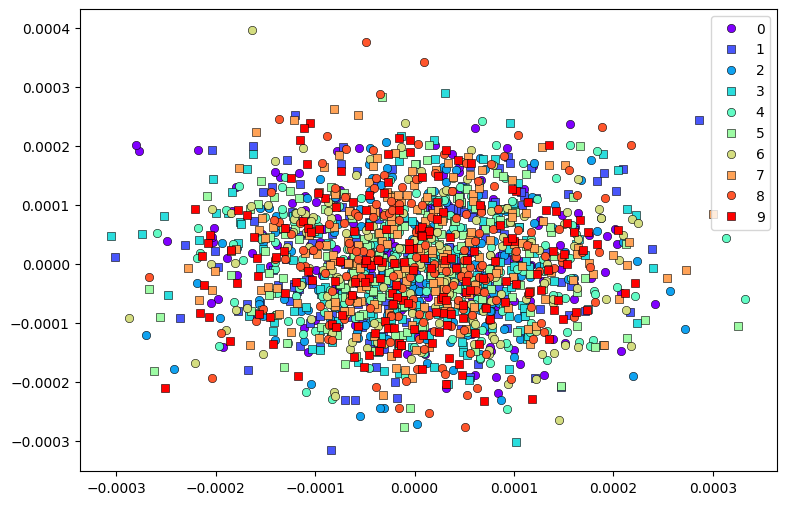

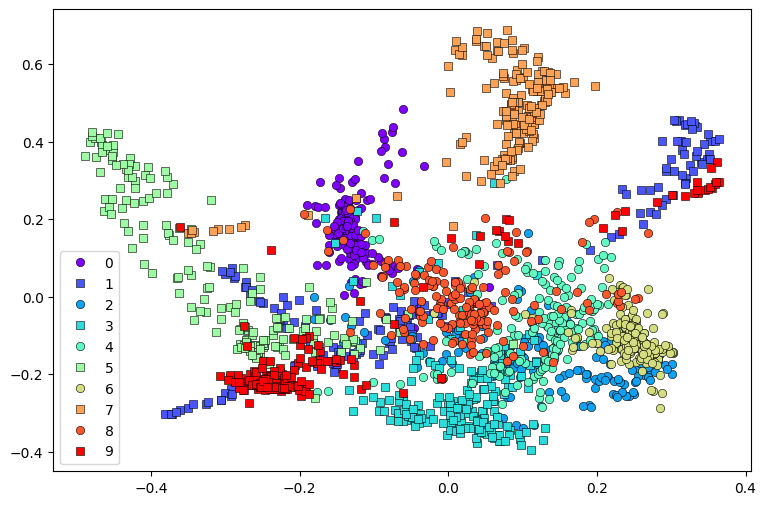

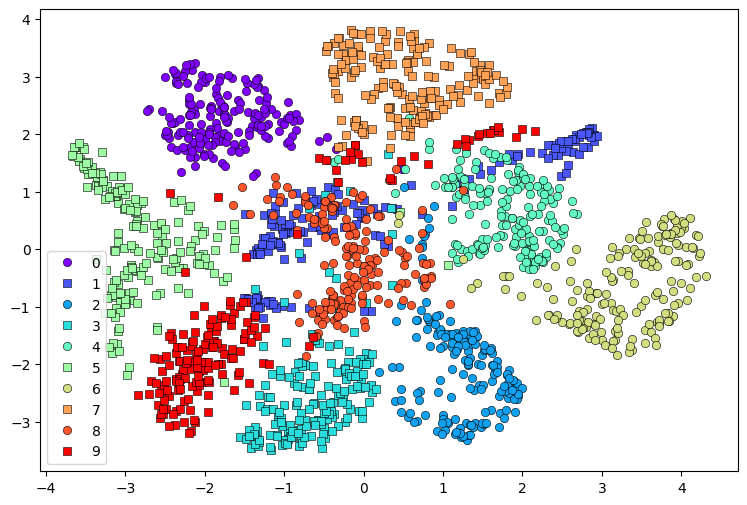

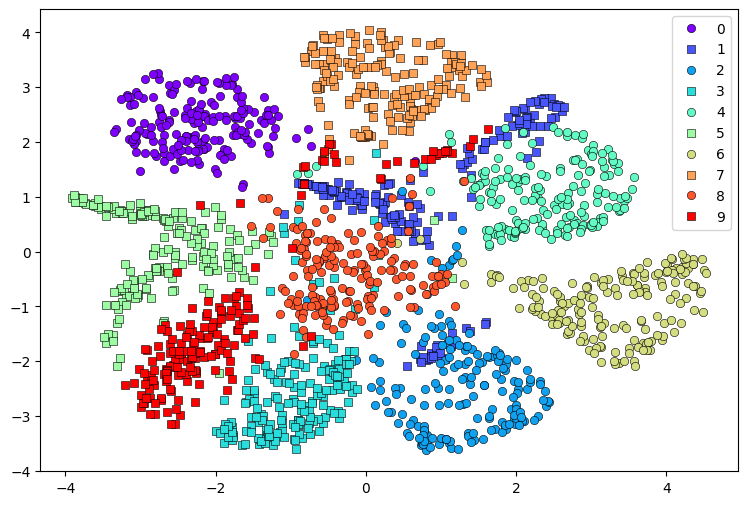

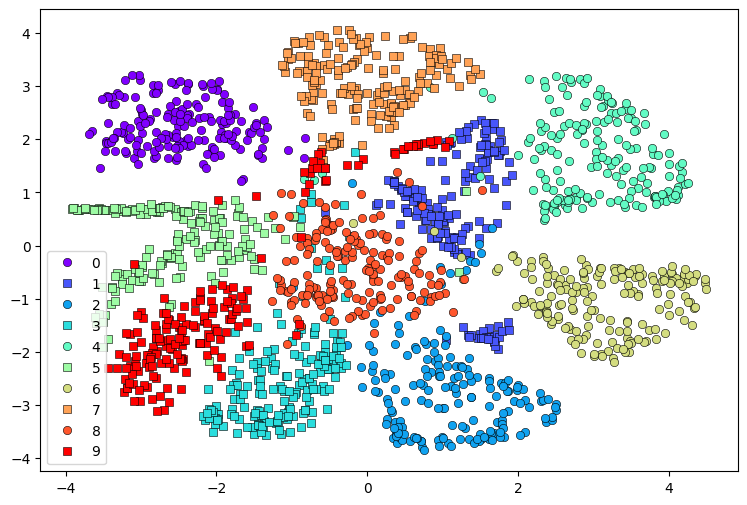

In [ ]:
SNE_hand(X, y)

😃
As we can see it appears that the Symmetric SNE is quite capable of understanding an underling structure in our data, even tough is not that skilled to separating them. BTW, what need to remain impressed is that we have been able to visualize an underling structure in 2-D of our images (that were living in 64 dimensions). **In this tutorial, what we are covering  is the main technique used today for visualization in ML.**

## Crodwing Problem

A fundamental problem with SNE and many other embedding techniques is that they tend to squeeze points that are relatively far away in the high dimensional space close together in the low dimensional (usually 2d) embedding space. **Could you see it in the result above?**. This is known as the **crowding problem**, and arises due to the use of squared errors (or Gaussian probabilities).
One solution to this is to use a probability distribution in lower-dimensional space that has heavier tails, which eliminates the unwanted attractive forces between points that are relatively far in the high dimensional space...

# ⏲ Let's get things serious: t-SNE

## Why?

Take [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) for example, a classic dataset of images of handwritten digits from 0 to 9. MNIST images are 28x28 pixels, meaning they live in 784-dimensional space. With t-SNE, we can reduce this to just two dimensions and understand perfectly underling structure.

Wasn't that one already the goal of using SNE?

Yes! but now we can do it **without the crowding problem**! 💥

Let's dive deeper in this Turing Award idea :)

> From now on we are going to focus on t-SNE. If you want to learn more about dimensionality reduction and visualization (using MNIST dataset)  consider reading [this blog from Chris Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

## Why the "t" in t-SNE

As said before, we want to use a probability distribution that has heavier tails, which eliminates the unwanted attractive forces between points that are relatively far in the high dimensional space.

**RECIPE TO AVOID CROWDING:**

An obvious choice is the Student-t distribution. In t-SNE, the degree of freedom parameter ν is set to 1, making the distribution equivalent to a Cauchy distribution:

$$
q_{ij} = \frac{(1 + ||z_i − z_j ||^2)^{-1}}{\sum_{k \neq l}(1 + ||z_k − z_l||^2)^{-1}}
$$

While we keep a Gaussian in the high-dimensional data space. For t-SNE, the gradient is calculated as follows:

$$
\nabla z_i L = 4 \sum_j (p_{ij} − q_{ij})(z_i − z_j)(1 + ||z_i − z_j||^2)^{-1}
$$

The gradient for symmetric (Gaussian) SNE is the same, but it lacks the $(1 + ||z_i − z_j ||^2 )^{-1}$ term. This term is crucial as it acts like an inverse square law, **implying that points in embedding space behave like stars and galaxies, which helps form many well-separated clusters (galaxies), each containing many stars tightly packed inside.** This can be particularly useful for separating different classes of data in an unsupervised way.

⚡ Intuitively: if I am using a Cauchy distribution in the embedded space, since it goes at zero way slower (heavy tailed), it pushes distant points even farther away in the final embedding. In other words, I need much more distance to obtain a distance that was small in the input space. This new distributions expands distances in the embedding and tends to separate clusters, but still does not care about global distances (as SNE was doing). Cauchy is heavy-tailed

Check out a comparison between the two distributions [here](https://web.ipac.caltech.edu/staff/fmasci/home/mystats/CauchyVsGaussian.pdf).




### Exercise

> Define a function `calculate_joint_probabilities_tsne` to compute the new $ \mathbf{q}_{ij}$

In [ ]:
# ✏️ your solution here

In [ ]:
# @title 👀 Solution

def calculate_joint_probabilities_tsne(Z):
    """t-SNE: Computes the joint probability matrix q_ij from
    the low-dimensional representation Y."""
    # Compute the negative squared Euclidean distances
    neg_squared_distances = negative_squared_euclidean_distances(Z)
    # Invert the distances, adjusting for the negative values
    inverse_distances = np.power(1. - neg_squared_distances, -1)
    # Set diagonal elements to zero, excluding self-comparisons
    np.fill_diagonal(inverse_distances, 0.)
    # Normalize to get joint probabilities
    return inverse_distances / np.sum(inverse_distances), inverse_distances

# Note: We use '1 - distances' rather than '1 + distances' because
# our distance function yields negative distances.


--------------------

### Exercise

> Define a function `tsne_grad` to compute the new gradient.

In [ ]:
# ✏️ your solution here

In [ ]:
# @title 👀 Solution

def calculate_tsne_gradient(P, Q, Z, inverse_distances):
    """Calculate the gradient of the t-SNE cost function with respect to the low-dimensional points Z."""
    probability_differences = P - Q  # Difference between joint probabilities P and Q
    expanded_diffs = np.expand_dims(probability_differences, 2)  # Expand for broadcasting
    z_differences = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)  # Differences between all pairs

    # Expand the inverse distances matrix for element-wise multiplication with y_differences
    expanded_distances = np.expand_dims(inverse_distances, 2)

    # Element-wise multiply by the expanded inverse distances matrix
    weighted_z_diffs = z_differences * expanded_distances

    # Compute the gradient by summing the weighted differences
    gradient = 4. * (expanded_diffs * weighted_z_diffs).sum(axis=1)
    return gradient


## t-SNE in action!

Let's try it out and see the differences between normal SNE.

In [ ]:
# global
PERPL = 30
RANDOM_SEED = 1                    # Seed for random number generation to ensure reproducibility
MOM = 0.9
STEP_SIZE = 10.
MAX_ITER = 500                     # Number of iterations for training
PLOTTING_FREQUENCY = 5             # Number of times to plot during training

def tSNE_hand(data_matrix, class_labels):
    # Set up a numpy RandomState instance for controlled randomness
    random_generator = np.random.RandomState(RANDOM_SEED)

    # Calculate the matrix of joint probabilities p_ij
    joint_probability_matrix = generate_joint_probability_matrix(data_matrix, PERPL)

    # Execute SNE or t-SNE model training
    reduced_dimensions = gd_sne(data_matrix, class_labels, joint_probability_matrix, random_generator,
                                      iterations = MAX_ITER,
                                      compute_q = calculate_joint_probabilities_tsne,
                                      compute_gradient = calculate_tsne_gradient,
                                      step_size = STEP_SIZE,
                                      use_momentum = MOM,
                                      visualization_frequency = PLOTTING_FREQUENCY)



In [ ]:
X.shape, y.shape

((1797, 64), (1797,))

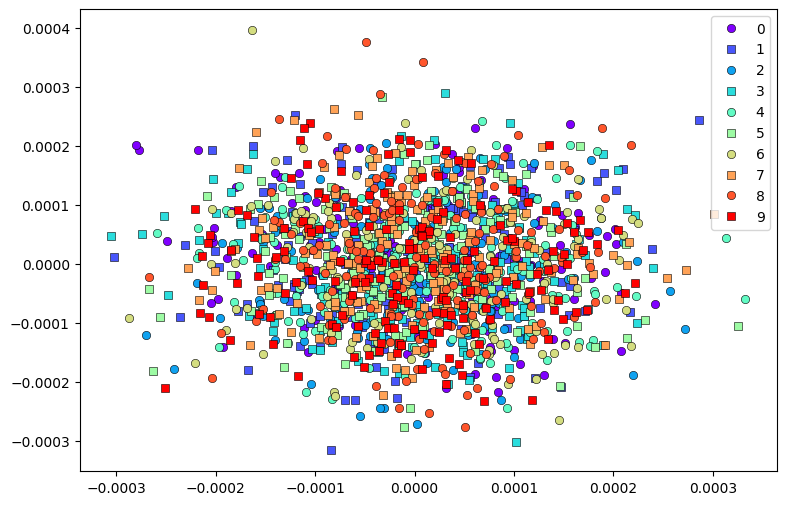

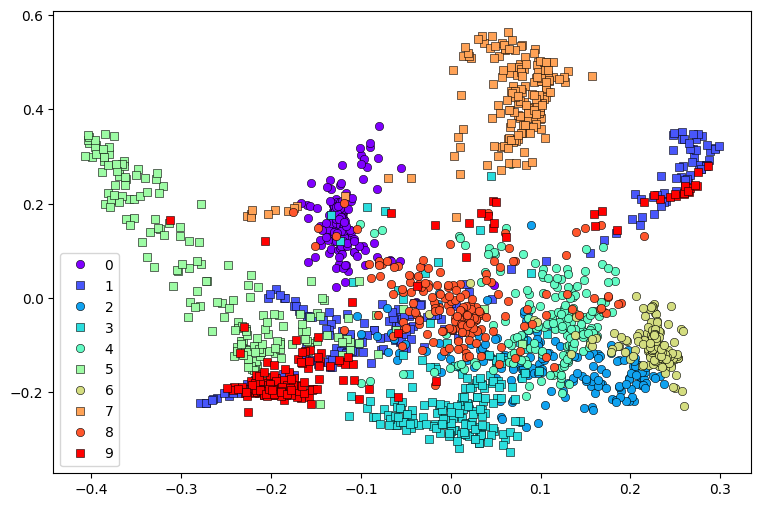

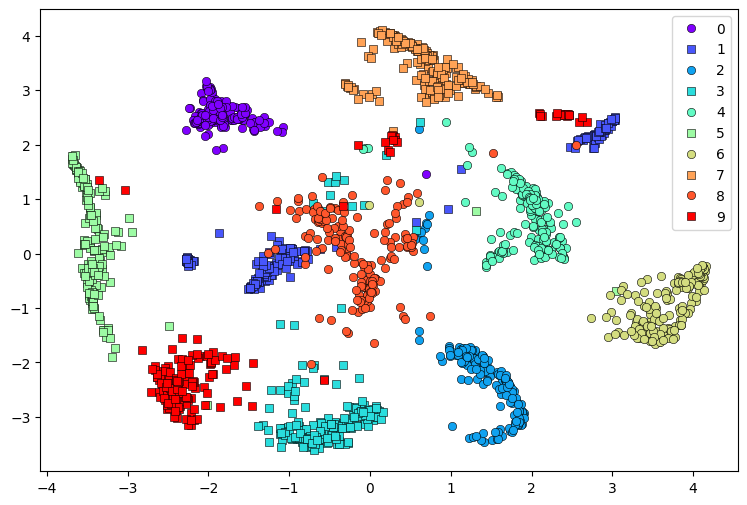

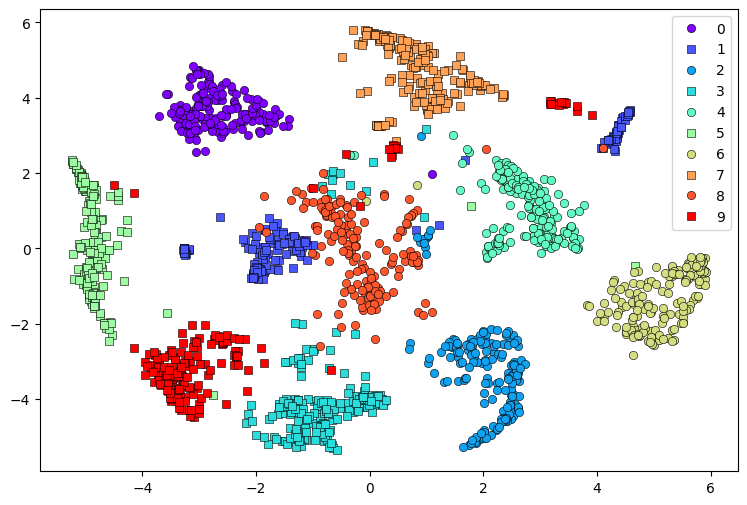

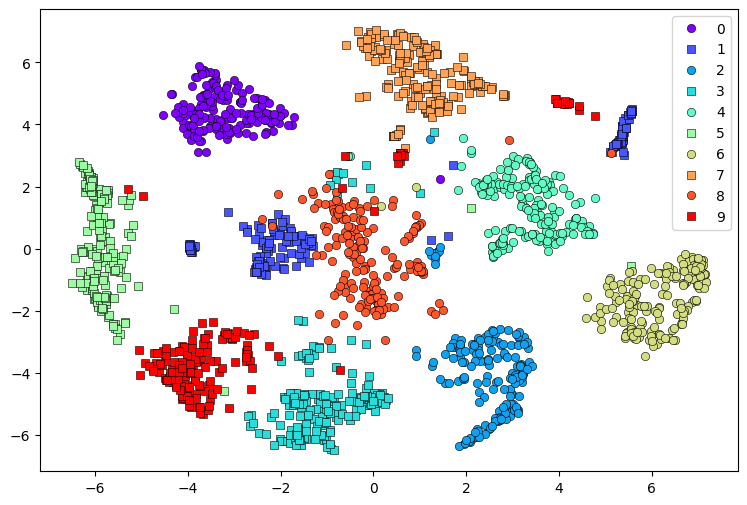

In [ ]:
tSNE_hand(X,y)

💫 The improvement is clear! Clusters are now much more evident and clear!

> **FUN TIME** Try to play with global parameters above. What can you see? Another fun website for this purpose is [this one](https://distill.pub/2016/misread-tsne/).

You will notice that the results of t-SNE can be quite sensitive to the perplexity parameter, so it is wise to run the algorithm with many different values. **If the perplexity is too small, the method tends to find structure within each cluster which is not truly present. At perplexity 30 (the default for scikit-learn), the clusters seem equi-distant in embedding space, even though some are closer than others in the data space.**

This may let you suppose that we cannot really trust how clusters are placed wrt each other...

To summarize, there is not a clear rule on how to choose the perplexity, you should try various options for you specific problem and understand which is the best one.

# t-SNE with Scikit-Learn - 2D vs 3D

From now on we'll use the Scikit-Learn version of t-SNE for semplicity (and testing). Please refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Implementing using just math, Python and Numpy is fun and informative, but usually implementations made by libraries are highly optimized and straightforward to use (even tough implementing t-SNE manually gives you greater flexibility to modify the algorithm according to your specific needs).

## Scikit learn on load digits

Let's see how the scikit learn version behaves with respect to the previous implementation.

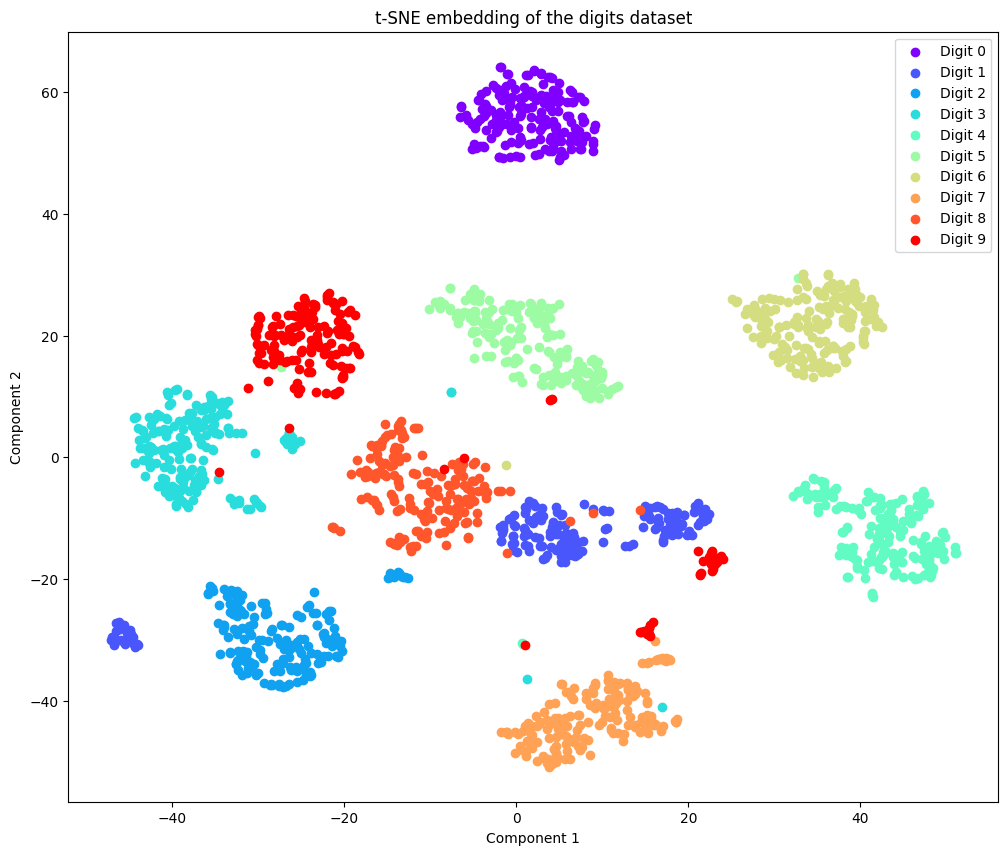

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=1) # perplexity = 30, lr = auto, iter_max = 1000. by default

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Plotting the result
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    mask = y == i
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], color=colors[i], label=f'Digit {i}')
plt.legend()
plt.title('t-SNE embedding of the digits dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Result is of course better (and much faster) than before! 😑

Let's see what happens in 3D.

### Exercise

> Provide a 3D embedding using Scikit-Learn function. Use Plotly for graphics.

In [ ]:
# ✏️ your solution here

In [ ]:
# @title 👀 Solution

from sklearn.manifold import TSNE
import plotly.express as px

# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Convert the embedded data into a DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(data=X_embedded, columns=['Component 1', 'Component 2', 'Component 3'])
df['digit'] = pd.Categorical(y)

# Plotting using Plotly
fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                    color='digit', labels={'color': 'Digit'},
                    title='3D t-SNE embedding of the digits dataset')
fig.update_traces(marker=dict(size=3))
fig.show()


Result is pretty solid!

This representation can lead to different analyses. For example, the clusters of numbers 3, 8, and 9 are quite close. This proximity is possibly because the numbers 3, 8, and 9 share visual traits that might be more easily confused compared to other numbers (**in fact their initial vectors in the input space were closer**). For instance, both 3 and 8 have closed curves at the top and bottom, and 9 is similar to 3 but inverted. These visual similarities can lead t-SNE to position them close to each other in two- or three-dimensional space, and possibly cause some confusion in the clustering process.

## Comparison between t-SNE, MDS and PCA

Let's compare them on the load digits dataset, both in 2D and 3D.

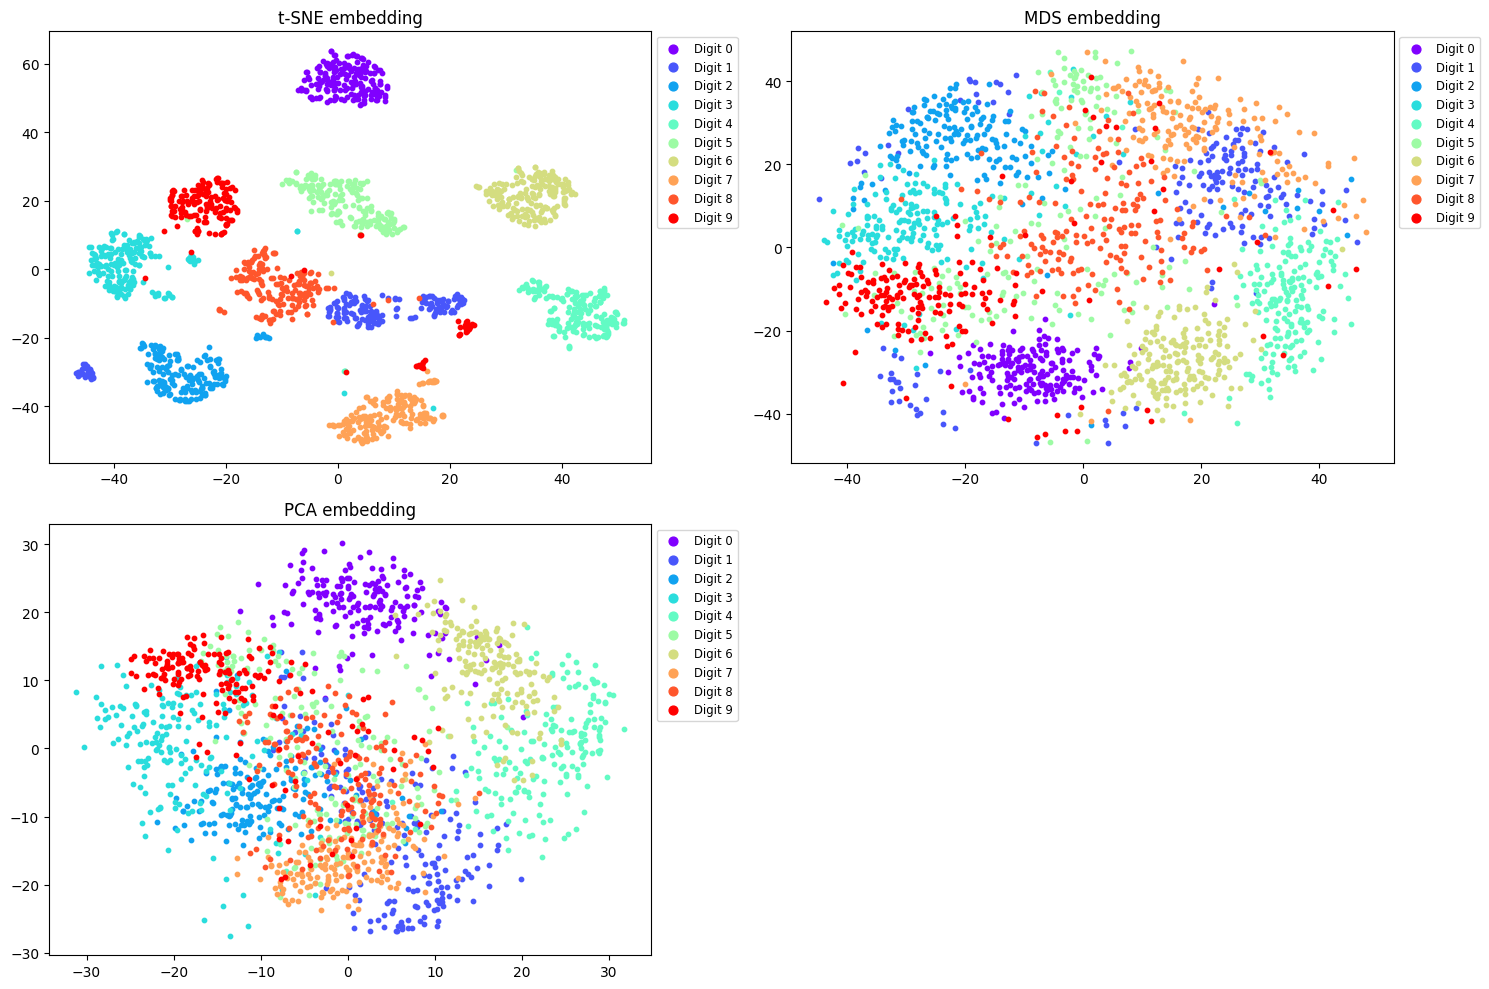

In [ ]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

# Set up the dimensionality reduction methods
tsne = TSNE(n_components=2, random_state=42)
mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
pca = PCA(n_components=2)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)
X_mds = mds.fit_transform(X)
X_pca = pca.fit_transform(X)

# Plotting function
def plot_embedding(X, title, subplot):
    ax = fig.add_subplot(2, 2, subplot)
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    for i in range(10):
        mask = y == i
        ax.scatter(X[mask, 0], X[mask, 1], color=colors[i], label=f'Digit {i}', s=10)
    ax.set_title(title)
    ax.legend(markerscale=2, loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))

# Create a figure to hold the subplots
fig = plt.figure(figsize=(15, 10))

# Add subplots for each embedding
plot_embedding(X_tsne, 't-SNE embedding', 1)
plot_embedding(X_mds, 'MDS embedding', 2)
plot_embedding(X_pca, 'PCA embedding', 3)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import plotly.graph_objects as go


# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Apply MDS
mds = MDS(n_components=3, random_state=0, normalized_stress='auto')
X_mds = mds.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=3, random_state=0, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X)

# Function to create 3D scatter plot
def plot_3d(X, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=y,                # set color to the target labels
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])
    fig.update_layout(title=title, scene=dict(
                        xaxis_title='Component 1',
                        yaxis_title='Component 2',
                        zaxis_title='Component 3'))
    return fig

# Create plots
fig_pca = plot_3d(X_pca, "PCA 3D Embedding")
fig_mds = plot_3d(X_mds, "MDS 3D Embedding")
fig_tsne = plot_3d(X_tsne, "t-SNE 3D Embedding")

fig_pca.show()
fig_mds.show()
fig_tsne.show()


👁 **Few observations:**

PCA does not capture the complex relationships or manifold structures in data (at least not completely, it does something btw). In this case, PCA does not seem to effectively separate different digit classes when they have nonlinear relationships. Same for MDS, but at least PCA is faster.

 In both 2D and 3D, t-SNE generally provides more distinct clustering of the digits compared to PCA and MDS. This makes it exceptionally suitable for tasks where distinguishing between similar categories is crucial. However, the computational cost and potential variability in outcomes should be considered.


# ✏ MNIST Dataset

Let's play with a larger dataset. MNIST is a large dataset that contains hand-written images.

In [ ]:
from sklearn import datasets

# Load the MNIST dataset
digits = datasets.fetch_openml('mnist_784', version=1, parser='pandas')
X = digits.data                 # (70000, 784)
y = digits.target.astype(int)   # (70000,)


⌛**Attention:** because of the size of the dataset, the algorithm execution will take a lot of time (even hours). Please, consider to adjust parameters `sample_size` and `num_iter` according to your needs.

Go and check out in the Scikit Learn documentation the default number of iterations for the algorithm...

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import plotly.graph_objects as go

# Select a subset of data for manageable computation
sample_size = 10000
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[indices]
y_sample = y[indices]

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# Apply MDS
mds = MDS(n_components=2, random_state=0, normalized_stress='auto')
X_mds = mds.fit_transform(X_sample)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X_sample)

# Function to create 2D scatter plot
def plot_2d(X, title):
    fig = go.Figure(data=[go.Scatter(
        x=X[:, 0],
        y=X[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=y_sample,                # set color to the target labels
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])
    fig.update_layout(title=title, xaxis_title='Component 1', yaxis_title='Component 2')
    return fig

# Create plots
fig_pca = plot_2d(X_pca, "PCA 2D Embedding of MNIST")
fig_mds = plot_2d(X_mds, "MDS 2D Embedding of MNIST")
fig_tsne = plot_2d(X_tsne, "t-SNE 2D Embedding of MNIST")

# Display plots
fig_pca.show()
fig_mds.show()
fig_tsne.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import plotly.graph_objects as go

# For performance, select a random subset of the data
sample_size = 10000
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[indices]
y_sample = y[indices]

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_sample)

# Apply MDS
mds = MDS(n_components=3, random_state=0, normalized_stress='auto')
X_mds = mds.fit_transform(X_sample)

# Apply t-SNE
tsne = TSNE(n_components=3, random_state=0, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X_sample)

# Function to create 3D scatter plot
def plot_3d(X, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=y_sample,                # set color to the target labels
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])
    fig.update_layout(title=title, scene=dict(
                        xaxis_title='Component 1',
                        yaxis_title='Component 2',
                        zaxis_title='Component 3'))
    return fig

# Create plots
fig_pca = plot_3d(X_pca, "PCA 3D Embedding of MNIST")
fig_mds = plot_3d(X_mds, "MDS 3D Embedding of MNIST")
fig_tsne = plot_3d(X_tsne, "t-SNE 3D Embedding of MNIST")

# Display plots (you can replace show() with write_html('filename.html') to save the plots as interactive HTML files)
fig_pca.show()
fig_mds.show()
fig_tsne.show()

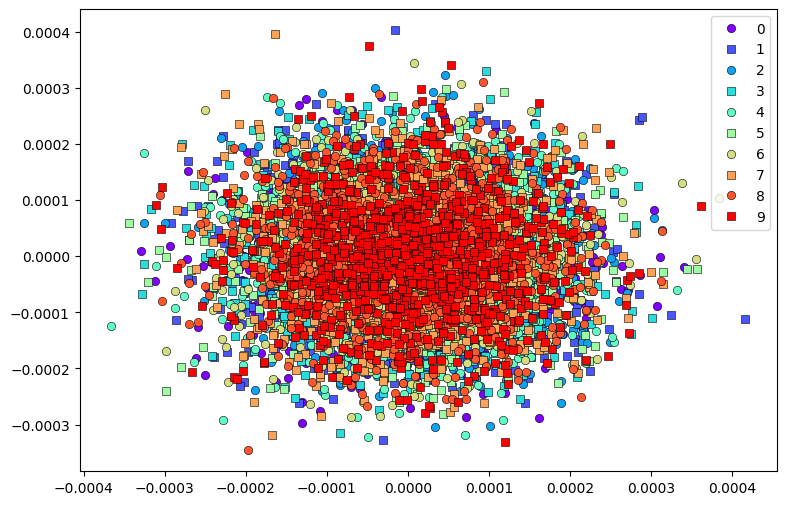

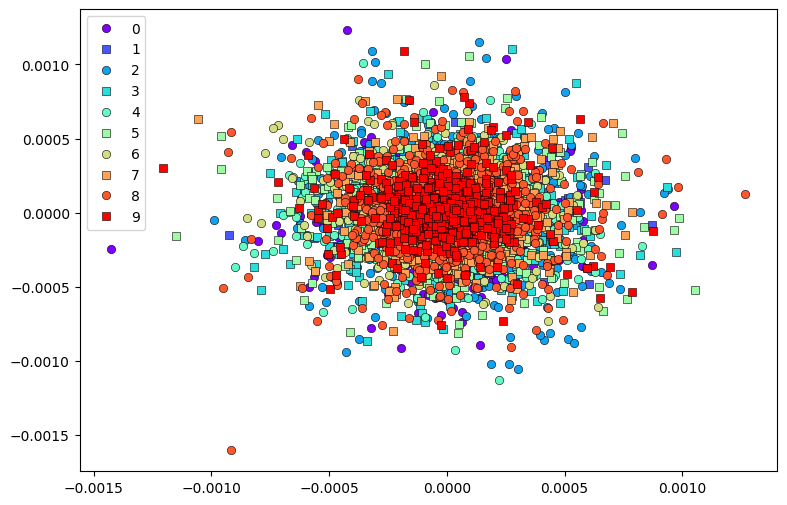

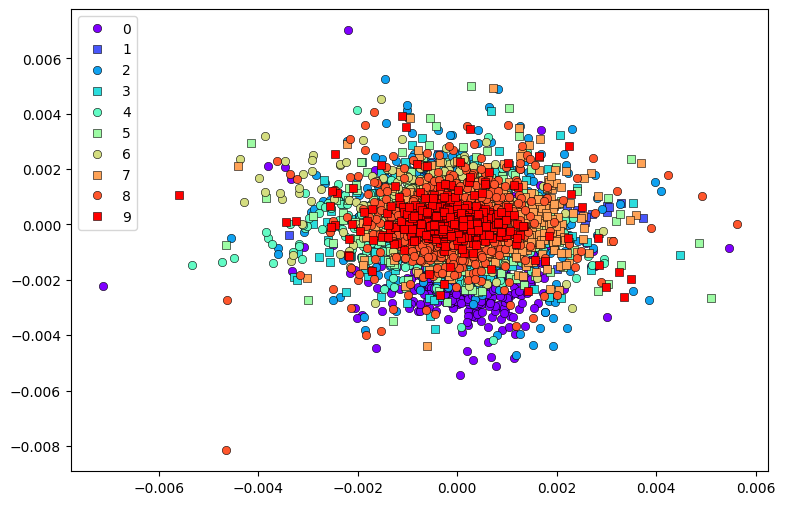

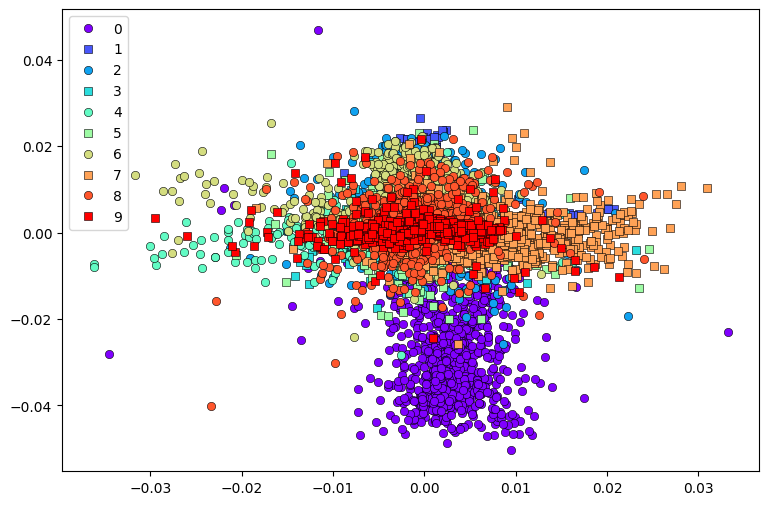

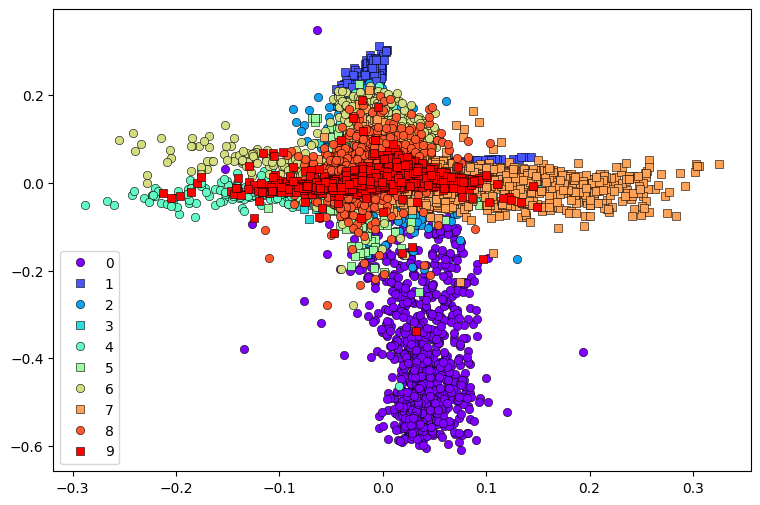

In [ ]:
# let's try with our first by-hand implementation of t-SNE
sample_size = 10000
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[indices].to_numpy()
y_sample = y[indices].to_numpy()
tSNE_hand(X_sample, y_sample)

### 🔎 Observations

**1. Effectiveness of t-SNE in High-Dimensional Data Clustering**

t-SNE has proven particularly effective in embedding and visualizing the MNIST dataset. Unlike PCA and MDS, which struggle to provide clear separations, t-SNE has successfully created well-defined clusters. This success is likely attributed to t-SNE’s ability to preserve local structures and neighborhoods, which is crucial for datasets with complex intrinsic structures like MNIST. The clear clustering observed suggests that t-SNE is adept at managing the nuances of high-dimensional data, making it a preferable choice for datasets where local relationships are more informative than global distances.

**2. Comparative Limitations of PCA and MDS**

Both PCA and MDS displayed limited effectiveness in visualizing the dataset adequately. PCA, which emphasizes variance maximization, and MDS, which aims to preserve global distances, could not capture the essential local patterns necessary for distinguishing between different digits effectively. This suggests that these techniques may be less suited for data where the principal components do not hold significant class-discriminative information, or the global distances are less indicative of class boundaries.

**3. Impact of Dataset Complexity and Size**

t-SNE performed slightly better on a previous project using the `load_digits` dataset, which is simpler and smaller compared to MNIST. This raises important points about the impact of dataset size and complexity on the effectiveness of dimensionality reduction techniques. It implies that t-SNE’s performance might be influenced by the scale and detail level of the data, where smaller datasets with less complex structures are more likely to yield clearer clusters.

**4. Error and Misclassification Issues**

Despite t-SNE’s relative success, there were slight (non neglectable) noted errors and misclassifications within the clusters (and with the implementation by-hand even more). These inaccuracies highlight potential limitations in the algorithm's ability to handle overlap between classes that are intrinsically similar or where the data points have ambiguous features.


--------------------

### Exercise

> Visualize the embedding created previously using a more informative color scheme. Then, draw further conclusions based on the new analysis.

# 📚 Resources/ inspirations

- http://colah.github.io/posts/2014-10-Visualizing-MNIST/
- https://github.com/robkravec/t-SNE-Implementation/tree/main
- https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/20/manifold_swiss_sklearn.ipynb
- https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
-  https://papers.nips.cc/paper_files/paper/2002/file/6150ccc6069bea6b5716254057a194ef-Paper.pdf
- https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- https://distill.pub/2016/misread-tsne/
- https://towardsdatascience.com/implementing-t-sne-in-tensorflow-manual-back-prop-in-tf-b08c21ee8e06
- 📘 Probabilistic Machine Learning- An Introduction -- Kevin P. Murphy
- 🤓 GPT
